In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

import cubnm
import cubnm_paper

# set plots font and dpi
# Note: the font is not included in the repository
import matplotlib.font_manager
font_path = os.path.join(cubnm_paper.config.DATA_DIR, 'assets', 'Optima.ttc')
matplotlib.font_manager.fontManager.addfont(font_path)
font = matplotlib.font_manager.FontProperties(fname=font_path, size=12)
plt.rcParams.update({
    "font.family": font.get_name(),
    "figure.dpi": 600
})

thcolor = '#44546A'

# Calculate reliability estimates

Load data for reliability analyses:

In [2]:
data = {}
opts = {}

for ses in ['REST1_LR', 'REST2_LR']:
    data[ses] = cubnm_paper.data.load_all_cmaes("twins_unrelated", ses, "yeo", n_runs=2)
    # create a dataframe of optimal parameters and cost function + components
    opts[ses] = pd.DataFrame({sub: data[ses][sub]['opt'] for sub in data[ses].keys()}).T

# subjects with data from both sessions
subs = sorted(list(
    set(data['REST1_LR'].keys()).intersection(set(data['REST2_LR'].keys())
)))

Loading all CMA-ES data from /raven/u/asaberi/projects/cubnm/paper/data/hcp/sim/yeo/all_cmaes_set-twins_unrelated_ses-REST1_LR_nruns-2.pkl
Loading all CMA-ES data from /raven/u/asaberi/projects/cubnm/paper/data/hcp/sim/yeo/all_cmaes_set-twins_unrelated_ses-REST2_LR_nruns-2.pkl


Calculate or load all ICCs:

In [3]:
pkl_file = os.path.join(cubnm_paper.config.DATA_DIR, 'hcp', 'iccs.pkl')

if os.path.exists(pkl_file):
    with open(pkl_file, 'rb') as f:
        iccs = pickle.load(f)
else:
    iccs = {}
    # create an empty sim group to use its get_sim_fc
    sg = cubnm.sim.rWWSimGroup(
        sc = np.zeros((100, 100)),
        duration=900,
        TR=0.72,
        exc_interhemispheric=True
    )
    sg.N = 1
    # FC
    for feature in ['sim_fc_tril', 'emp_fc_tril']:
        # edge-level
        n_edges = data['REST1_LR'][subs[0]][feature].shape[0]
        feature_icc = np.zeros(n_edges, dtype=float)
        for i in tqdm(range(n_edges)):
            icc_df = pd.DataFrame(index=subs, columns=['REST1_LR', 'REST2_LR'], dtype=float)
            for sub in subs:
                for ses in ['REST1_LR', 'REST2_LR']:
                    icc_df.loc[sub, ses] = data[ses][sub][feature][i]
            feature_icc[i] = cubnm_paper.utils.icc(icc_df.loc[:, 'REST1_LR'], icc_df.loc[:, 'REST2_LR'])
        iccs[feature.replace('_tril', '_edge')] = feature_icc
        # node-level strength
        feature_icc = np.zeros(100, dtype=float)
        for i in tqdm(range(100)):
            icc_df = pd.DataFrame(index=subs, columns=['REST1_LR', 'REST2_LR'], dtype=float)
            for sub in subs:
                for ses in ['REST1_LR', 'REST2_LR']:
                    # convert fc tril to squared matrix
                    sg.sim_fc_trils = data[ses][sub][feature][None, :]
                    fc_2d = sg.get_sim_fc(0)
                    # set diagonal to nan (excluding self-connections)
                    np.fill_diagonal(fc_2d, np.nan)
                    icc_df.loc[sub, ses] = np.nansum(fc_2d[i, :])
            feature_icc[i] = cubnm_paper.utils.icc(icc_df.loc[:, 'REST1_LR'], icc_df.loc[:, 'REST2_LR'])
        iccs[feature.replace('_tril', '_strength')] = feature_icc
    # state variables
    state_vars = ['I_E', 'r_E', 'S_E', 'I_I', 'r_I', 'S_I']
    for var in state_vars:
        iccs[var] = np.zeros(100, dtype=float)
        for i in tqdm(range(100)):
            icc_df = pd.DataFrame(index=subs, columns=['REST1_LR', 'REST2_LR'], dtype=float)
            for sub in subs:
                for ses in ['REST1_LR', 'REST2_LR']:
                    icc_df.loc[sub, ses] = data[ses][sub]['states'][var][i]
            iccs[var][i] = cubnm_paper.utils.icc(icc_df.loc[:, 'REST1_LR'], icc_df.loc[:, 'REST2_LR'])
    # parameters
    params = ['G'] + [f'w_p{i}' for i in range(7)] + [f'J_N{i}' for i in range(7)]
    for param in params:
        iccs[param] = cubnm_paper.utils.icc(
            opts['REST1_LR'].loc[subs, param], 
            opts['REST2_LR'].loc[subs, param]
        )
    with open(pkl_file, 'wb') as f:
        pickle.dump(iccs, f)

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


For FCD, calculate the KS between sessions within each subject:

In [4]:
fcd_ks = {}

for src in ['emp', 'sim']:
    fcd_ks[src] = np.zeros(len(subs), dtype=float)
    for i, sub in tqdm(enumerate(subs)):
        fcds = {}
        for ses in ['REST1_LR', 'REST2_LR']:
            fcds[ses] = data[ses][sub][f'{src}_fcd_tril']
        fcd_ks[src][i] = scipy.stats.ks_2samp(fcds['REST1_LR'], fcds['REST2_LR']).statistic

217it [00:01, 123.30it/s]
217it [00:01, 174.65it/s]


# Load heritability estimates

Output CSVs (`output.csv`) have been calculated and created via `scripts/heritability/calculate_h2.py`.
Here we load them for plotting:

In [6]:
h2s = {}

SOLAR_ROOT = os.path.join(
    cubnm_paper.config.DATA_DIR, 'hcp', 
    'solar', 'REST1_LR_REST2_LR'
)
    
for analysis in sorted(os.listdir(SOLAR_ROOT)):
    print(analysis)
    solar_out = pd.read_csv(
        os.path.join(SOLAR_ROOT, analysis, 'output.csv'),
        index_col = 0
    )
    # drop duplicate rows (last index is duplicated in solar output)
    solar_out = solar_out.loc[~solar_out.index.duplicated(keep='first')]
    # drop node- or edge- prefix
    if (
        solar_out.index[0].startswith('node')
        or solar_out.index[0].startswith('edge')
    ):
        solar_out.index = solar_out.index.map(lambda s: int(s.replace('node_','').replace('edge_','')))
    # sort by index
    solar_out = solar_out.sort_index()
    
    h2s[analysis] = solar_out

I_E
I_I
S_E
S_I
emp_fc_edge
emp_fc_strength
params
r_E
r_I
sc_edge
sc_strength
sim_fc_edge
sim_fc_strength


# Plot

Convert ICCs to long format for easier plotting:

In [7]:
iccs_long = []
for k, icc_arr in iccs.items():
    if k.endswith('fc_edge'):
        category = 'fc_edge'
    elif k.endswith('fc_strength'):
        category = 'fc_strength'
    elif k.endswith('_I') or k.endswith('_E'):
        category = 'state'
    else:
        category = 'param'
    if isinstance(icc_arr, np.ndarray):
        for i in range(icc_arr.shape[0]):
            iccs_long.append({
                'empirical': 'emp' in k,
                'category': category,
                'what': k,
                'index': i,
                'icc': icc_arr[i]
            })
    else:
        iccs_long.append({
            'empirical': 'emp' in k,
            'category': category,
            'what': k,
            'index': np.nan,
            'icc': icc_arr
        })

iccs_long = pd.DataFrame(iccs_long)
iccs_long.head()

,empirical,category,what,index,icc
0,False,fc_edge,sim_fc_edge,0.0,0.644155
1,False,fc_edge,sim_fc_edge,1.0,0.641803
2,False,fc_edge,sim_fc_edge,2.0,0.701377
3,False,fc_edge,sim_fc_edge,3.0,0.634334
4,False,fc_edge,sim_fc_edge,4.0,0.685512


Same for H2s:

In [8]:
h2s_long = []
for k, h2_df in h2s.items():
    if k.endswith('edge'):
        category = 'edge'
    elif k.endswith('strength'):
        category = 'strength'
    elif k.endswith('_I') or k.endswith('_E'):
        category = 'state'
    else:
        category = 'param'
    if category == 'param':
        for param in h2_df.index:
            h2s_long.append({
                'empirical': False,
                'sc': False,
                'category': category,
                'what': param,
                'index': np.nan,
                'h2': h2_df.loc[param, 'h2r']
            })
    else:
        for i in range(h2_df.shape[0]):
            h2s_long.append({
                'empirical': ('emp' in k) or (k.startswith('sc')),
                'sc': k.startswith('sc'),
                'category': category,
                'what': k,
                'index': i,
                'h2': h2_df['h2r'].values[i]
            })

h2s_long = pd.DataFrame(h2s_long)
h2s_long.head()

,empirical,sc,category,what,index,h2
0,False,False,state,I_E,0.0,0.303200
1,False,False,state,I_E,1.0,0.227307
2,False,False,state,I_E,2.0,0.344369
3,False,False,state,I_E,3.0,0.255351
4,False,False,state,I_E,4.0,0.302093


Plot:

/tmp/ipykernel_29582/3356406052.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Empirical', 'Simulated'], rotation=90, fontsize=fontsize)
/tmp/ipykernel_29582/3356406052.py:249: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29582/3356406052.py:249: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29582/3356406052.py:249: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29582/3356406052.py:249: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtic

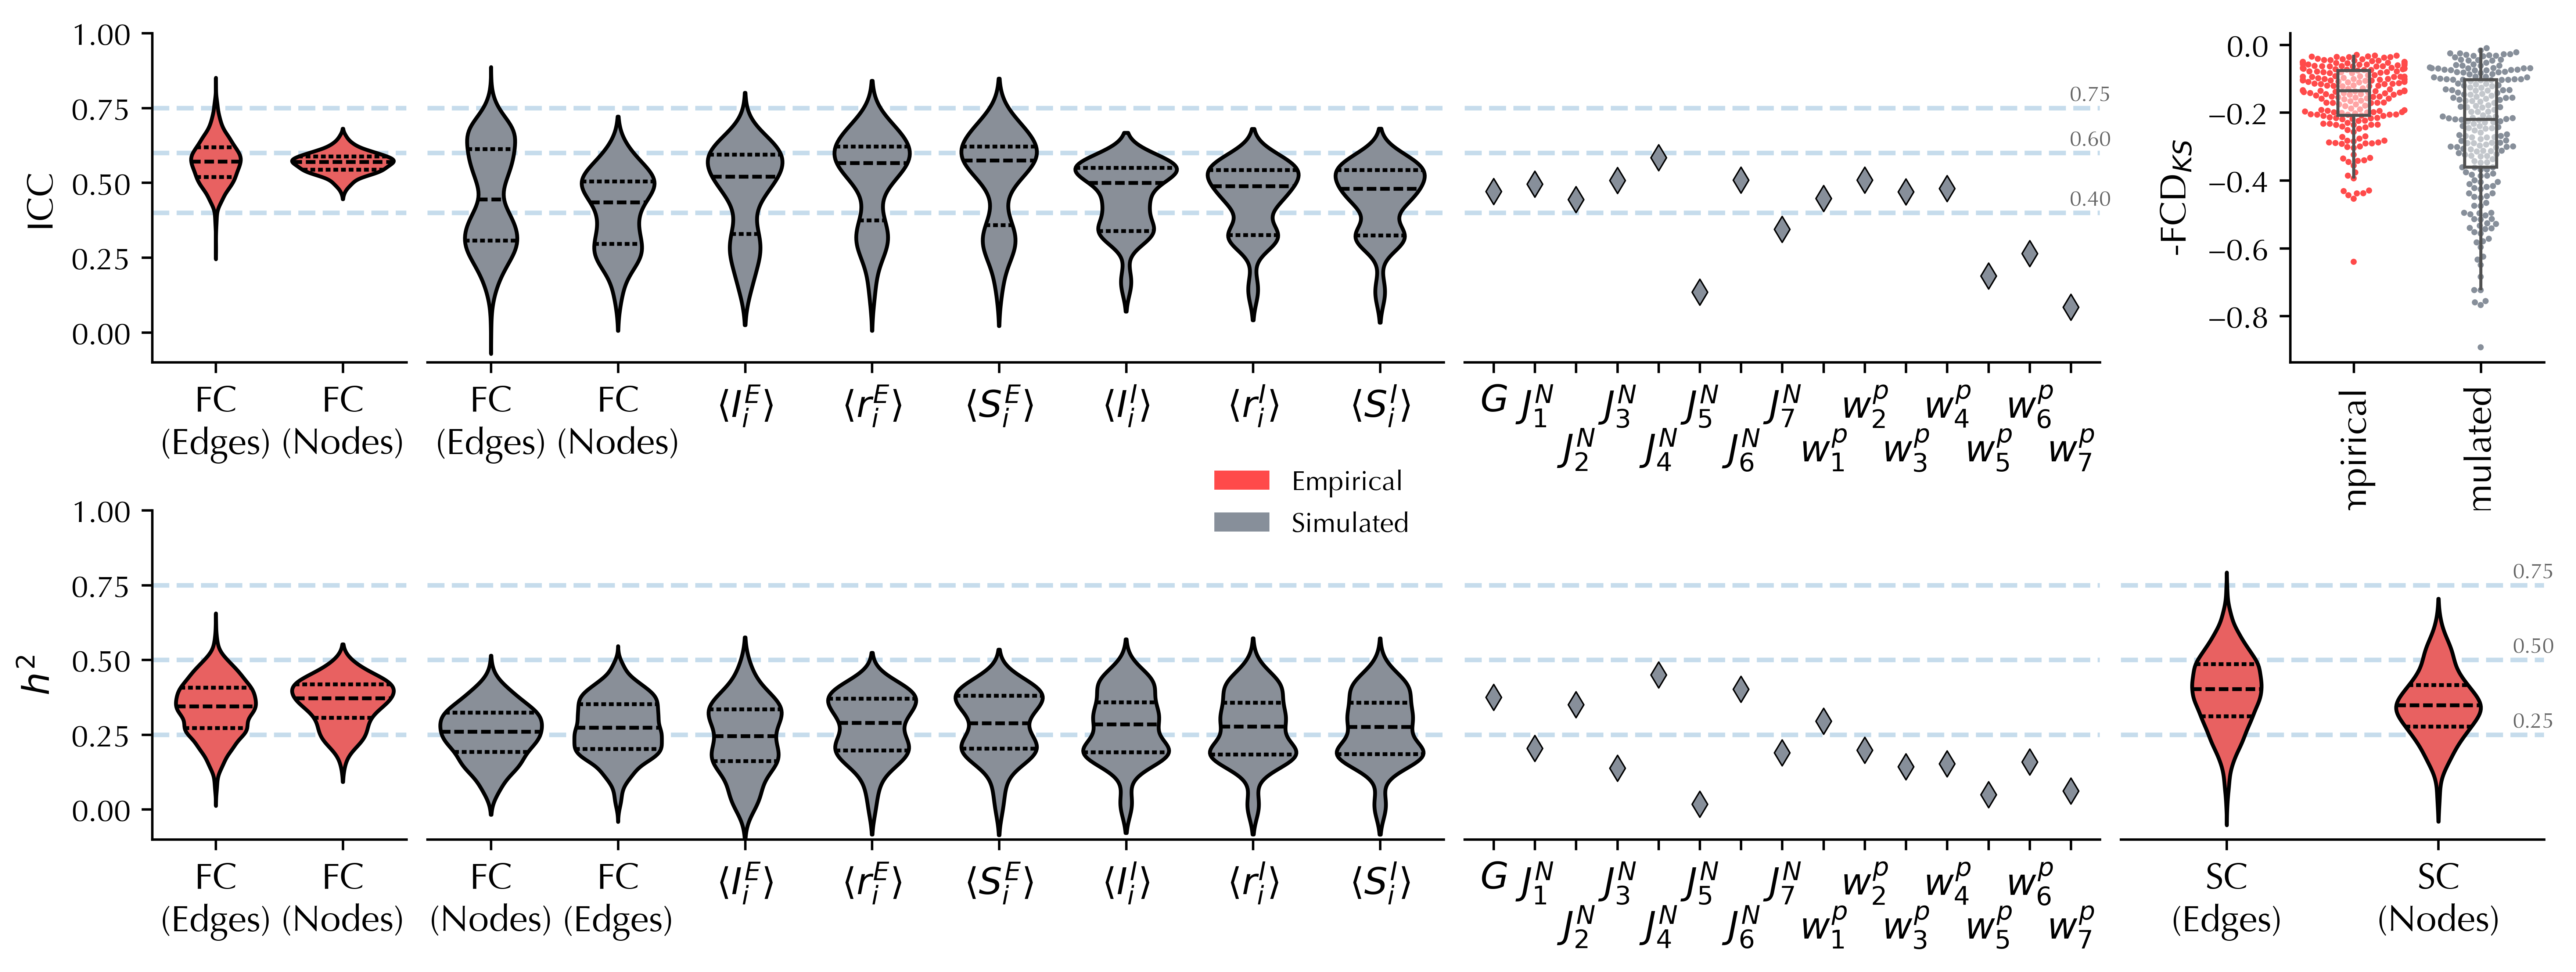

In [9]:
### Settings ###
alpha = 1.0 # to make sure the indicator lines are behind everything else
emp_color = '#ff4a4a' # looks similar to red + alpha = 0.65
sim_color = '#878f9a'
linecolor = 'black'
width = 0.8
ticklabel_rotation = 0
fontsize=12

### Labels ###
labels = {
    'sim_fc_edge': 'FC\n(Edges)',
    'emp_fc_edge': 'FC\n(Edges)',
    'sim_fc_strength': 'FC\n(Nodes)',
    'emp_fc_strength': 'FC\n(Nodes)',
    'sc_edge': 'SC\n(Edges)',
    'sc_strength': 'SC\n(Nodes)'
}
state_vars = sg.state_names
for var in state_vars:
    state_var, neuron = var.split('_')
    # labels[var] = r'$\langle '+state_var+r'^'+neuron+r'_i(t) \rangle_{i,t}$'
    labels[var] = r'$\langle '+state_var+r'^'+neuron+r'_i \rangle$'
params = iccs_long.loc[(iccs_long['category']=='param'), 'what'].values
for i, param in enumerate(params):
    if '_' in param:
        # w_p and J_N
        labels[param] = r'$'+param[0]+r'_'+str(int(param[-1])+1)+r'^'+param[2]+r'$' # 0-index to 1-index
    else:
        # G
        labels[param] = r'$'+param+r'$'
    # put every other parameter after a newline to space them better
    if (i+1)%2==0:
        labels[param] = '\n'+labels[param]
    


### Layout ###
fig, axd = plt.subplot_mosaic(
    [
        ["emp_arrays", "space0",   "sim_arrays", "space1",  "params",    "space2",  "space3",    "fcd"],
        ["emp_fc_h2",  "space0h",  "sim_h2",     "space1h", "params_h2", "space2h", "sc_h2",     "sc_h2"],
    ],
    width_ratios=[0.6, 0.05, 2.4, 0.05, 1.5, 0.05, 0.4, 0.6],
    figsize=(14, 4.75),
)
# list of axes for the vertical lines
icc_axes = ["emp_arrays", "sim_arrays",  "params"]
h2_axes = ["emp_fc_h2", "sim_h2", "params_h2", "sc_h2"]

### ICC emp arrays ###
ax = axd["emp_arrays"]
plot_data = iccs_long.loc[iccs_long['empirical']]
sns.violinplot(
    data=plot_data, 
    x='what', 
    y='icc',
    color=emp_color,
    linecolor=linecolor,
    inner='quart',
    width=width,
    alpha=alpha, 
    legend=False,
    ax=ax,
)
ax.set_ylabel("ICC", fontsize=fontsize)
sns.despine(ax=ax)

### ICC sim arrays ###
ax = axd["sim_arrays"]
plot_data = iccs_long.loc[
    (iccs_long['category']!='param') &
    ~(iccs_long['empirical'])
]
sns.violinplot(
    data=plot_data, 
    x='what', 
    y='icc',
    color=sim_color, 
    linecolor=linecolor,
    inner='quart',
    width=width,
    alpha=alpha, 
    legend=False,
    ax=ax,
)
sns.despine(left=True, ax=ax)
ax.get_yaxis().set_visible(False)

### ICC params ###
ax = axd["params"]
plot_data = iccs_long.loc[iccs_long['category']=='param'].sort_values('what')
sns.scatterplot(
    data=plot_data,
    x='what',
    y='icc',
    marker='d',
    color=sim_color,
    edgecolor=linecolor,
    alpha=alpha,
    ax=ax
)
sns.despine(left=True, ax=ax)
ax.get_yaxis().set_visible(False)

### FCD KS ###
ax = axd["fcd"]
plot_data = (-pd.DataFrame(fcd_ks)).unstack().reset_index()
sns.swarmplot(
    data=plot_data,
    x='level_0', 
    y=0,
    palette=[emp_color, sim_color],
    alpha=alpha,
    s=2,
    ax=ax
)
sns.boxplot(
    data=plot_data, 
    x='level_0', 
    y=0,
    showfliers=False,
    showcaps=False, width=0.25,
    boxprops={"facecolor": (1, 1, 1, 0.5)},
    ax=ax
)
plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back

ax.set_ylabel(r'-FCD$_{KS}$', fontsize=fontsize)
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(['Empirical', 'Simulated'], rotation=90, fontsize=fontsize)

### H2 empirical FC ###
ax = axd["emp_fc_h2"]
plot_data = h2s_long.loc[
    h2s_long['empirical'] & ~h2s_long['sc']
]
sns.violinplot(
    data=plot_data, 
    x='what', 
    y='h2',
    order=[
        'emp_fc_edge', 'emp_fc_strength', 
    ],
    color=emp_color,
    linecolor=linecolor,
    inner='quart',
    width=width,
    alpha=alpha, 
    legend=False,
    ax=ax,
)

ax.set_ylabel("$h^2$", fontsize=fontsize)
sns.despine(ax=ax)

### H2 simulated arrays ###
ax = axd["sim_h2"]
plot_data = h2s_long.loc[
    (h2s_long['category']!='param') &
    ~(h2s_long['empirical'])
]
sns.violinplot(
    data=plot_data, 
    x='what', 
    y='h2',
    order=[
        'sim_fc_strength', 'sim_fc_edge', 
        'I_E', 'r_E', 'S_E', 'I_I', 'r_I', 'S_I'
    ],
    color=sim_color, 
    linecolor=linecolor,
    inner='quart',
    width=width,
    alpha=alpha, 
    legend=False,
    ax=ax,
)
sns.despine(left=True, ax=ax)
ax.get_yaxis().set_visible(False)

### H2 params ###
ax = axd["params_h2"]
plot_data = h2s_long.loc[h2s_long['category']=='param'].sort_values('what')
sns.scatterplot(
    data=plot_data,
    x='what',
    y='h2',
    marker='d',
    color=sim_color,
    edgecolor=linecolor,
    alpha=alpha,
    ax=ax
)
sns.despine(left=True, ax=ax)
ax.get_yaxis().set_visible(False)

### H2 empirical SC ###
ax = axd["sc_h2"]
plot_data = h2s_long.loc[
    h2s_long['empirical'] & h2s_long['sc']
]
sns.violinplot(
    data=plot_data, 
    x='what', 
    y='h2',
    order=[
        'sc_edge', 'sc_strength', 
    ],
    color=emp_color,
    linecolor=linecolor,
    inner='quart',
    width=width*0.5,
    alpha=alpha, 
    legend=False,
    ax=ax,
)
sns.despine(left=True, ax=ax)
ax.get_yaxis().set_visible(False)

### Legend ###
ax = axd["sim_h2"]
# Create legend elements
from matplotlib.patches import Patch
handles = [
    Patch(facecolor=emp_color, alpha=alpha, label='Empirical'),
    Patch(facecolor=sim_color, alpha=alpha, label='Simulated')
]

legend = ax.legend(
    handles=handles,
    loc='upper left', 
    frameon=False,
    fontsize=fontsize*0.75,
    bbox_to_anchor=(0.75, 1.2)
)

### Aesthetics ###
for k, ax in axd.items():
    if k == "fcd":
        continue
    elif k.startswith('space'):
        ax.set_ylim([-0.1, 1])
        ax.axis('off')
    else:
        ax.set_ylim([-0.1, 1])
        ax.set_xlabel('')
        ax.set_xticklabels(
            map(lambda s: labels.get(s.get_text(), s.get_text()), ax.get_xticklabels()),
            rotation=0 if k.startswith('params') else ticklabel_rotation, 
            fontsize=fontsize
        )
    # add horizontal indicator lines
    if k in icc_axes:
        for y in [0.4, 0.6, 0.75]:
            ax.axhline(y, ls='--', alpha=0.25, zorder=0)
            if k == icc_axes[-1]:
                ax.text(
                    ax.get_xlim()[-1]*0.95,
                    y+0.025,
                    f'{y:.2f}',
                    fontsize=7,
                    color='.4',
                )
    if k in h2_axes:
        for y in [0.25, 0.5, 0.75]:
            ax.axhline(y, ls='--', alpha=0.25, zorder=0)
            if k == h2_axes[-1]:
                ax.text(
                    ax.get_xlim()[-1]*0.90,
                    y+0.025,
                    f'{y:.2f}',
                    fontsize=7,
                    color='.4',
                )

plt.subplots_adjust(wspace=0, hspace=0.45)
fig.savefig('icc_h2.png', transparent=True, bbox_inches='tight')

# Descriptives

In [10]:
for k in iccs:
    if isinstance(iccs[k], float):
        continue
    display(k)
    display(pd.Series(iccs[k]).describe().round(3))

'sim_fc_edge'

count    2450.000
mean        0.455
std         0.173
min         0.001
25%         0.306
50%         0.444
75%         0.613
max         0.814
dtype: float64

'sim_fc_strength'

count    100.000
mean       0.409
std        0.128
min        0.107
25%        0.296
50%        0.435
75%        0.504
max        0.620
dtype: float64

'emp_fc_edge'

count    2450.000
mean        0.570
std         0.074
min         0.276
25%         0.518
50%         0.570
75%         0.619
max         0.820
dtype: float64

'emp_fc_strength'

count    100.000
mean       0.567
std        0.035
min        0.473
25%        0.543
50%        0.569
75%        0.588
max        0.653
dtype: float64

'I_E'

count    100.000
mean       0.471
std        0.149
min        0.143
25%        0.329
50%        0.520
75%        0.593
max        0.683
dtype: float64

'r_E'

count    100.000
mean       0.512
std        0.151
min        0.126
25%        0.374
50%        0.565
75%        0.621
max        0.721
dtype: float64

'S_E'

count    100.000
mean       0.514
std        0.155
min        0.145
25%        0.358
50%        0.574
75%        0.621
max        0.725
dtype: float64

'I_I'

count    100.000
mean       0.455
std        0.111
min        0.159
25%        0.339
50%        0.499
75%        0.550
max        0.579
dtype: float64

'r_I'

count    100.000
mean       0.446
std        0.116
min        0.133
25%        0.325
50%        0.488
75%        0.543
max        0.588
dtype: float64

'S_I'

count    100.000
mean       0.444
std        0.117
min        0.126
25%        0.324
50%        0.480
75%        0.543
max        0.588
dtype: float64

In [11]:
pd.DataFrame(fcd_ks).describe().round(3)

,emp,sim
count,217.000,217.000
mean,0.157,0.256
std,0.102,0.182
min,0.030,0.010
25%,0.077,0.104
50%,0.136,0.220
75%,0.209,0.362
max,0.640,0.892


In [12]:
for k in h2s:
    display(k)
    display(h2s[k]['h2r'].describe().round(3))

'I_E'

count    100.000
mean       0.240
std        0.119
min        0.000
25%        0.161
50%        0.245
75%        0.334
max        0.481
Name: h2r, dtype: float64

'I_I'

count    100.000
mean       0.275
std        0.113
min        0.012
25%        0.191
50%        0.284
75%        0.358
max        0.479
Name: h2r, dtype: float64

'S_E'

count    100.000
mean       0.283
std        0.108
min        0.000
25%        0.203
50%        0.288
75%        0.379
max        0.449
Name: h2r, dtype: float64

'S_I'

count    100.000
mean       0.269
std        0.113
min        0.006
25%        0.185
50%        0.276
75%        0.356
max        0.483
Name: h2r, dtype: float64

'emp_fc_edge'

count    2450.000
mean        0.340
std         0.094
min         0.052
25%         0.272
50%         0.345
75%         0.408
max         0.616
Name: h2r, dtype: float64

'emp_fc_strength'

count    100.000
mean       0.358
std        0.077
min        0.154
25%        0.306
50%        0.371
75%        0.418
max        0.491
Name: h2r, dtype: float64

'params'

count    15.000
mean      0.212
std       0.134
min       0.018
25%       0.141
50%       0.189
75%       0.323
max       0.450
Name: h2r, dtype: float64

'r_E'

count    100.000
mean       0.276
std        0.105
min        0.000
25%        0.197
50%        0.289
75%        0.370
max        0.440
Name: h2r, dtype: float64

'r_I'

count    100.000
mean       0.270
std        0.113
min        0.007
25%        0.184
50%        0.276
75%        0.357
max        0.483
Name: h2r, dtype: float64

'sc_edge'

count    2450.000
mean        0.396
std         0.124
min         0.000
25%         0.311
50%         0.402
75%         0.486
max         0.740
Name: h2r, dtype: float64

'sc_strength'

count    100.000
mean       0.349
std        0.110
min        0.047
25%        0.276
50%        0.349
75%        0.415
max        0.617
Name: h2r, dtype: float64

'sim_fc_edge'

count    2450.000
mean        0.275
std         0.098
min         0.000
25%         0.202
50%         0.273
75%         0.352
max         0.505
Name: h2r, dtype: float64

'sim_fc_strength'

count    100.000
mean       0.256
std        0.088
min        0.053
25%        0.192
50%        0.260
75%        0.323
max        0.445
Name: h2r, dtype: float64

# Statistical comparison of empirical and simulated FC ICC and H2s + SC for H2s

In [13]:
x1 = iccs['sim_fc_edge']
x2 = iccs['emp_fc_edge'] 

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -33.48, p: 0.000


count    2450.000
mean       -0.115
std         0.170
min        -0.711
25%        -0.243
50%        -0.115
75%         0.025
max         0.290
dtype: float64

In [14]:
x1 = iccs['sim_fc_strength']
x2 = iccs['emp_fc_strength'] 

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -12.40, p: 0.000


count    100.000
mean      -0.158
std        0.127
min       -0.478
25%       -0.265
50%       -0.131
75%       -0.068
max        0.076
dtype: float64

In [15]:
x1 = h2s['sim_fc_edge']['h2r'].values
x2 = h2s['emp_fc_edge']['h2r'].values

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -25.75, p: 0.000


count    2450.000
mean       -0.065
std         0.125
min        -0.440
25%        -0.155
50%        -0.073
75%         0.016
max         0.372
dtype: float64

In [16]:
x1 = h2s['sim_fc_edge']['h2r'].values
x2 = h2s['sc_edge']['h2r'].values

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -36.91, p: 0.000


count    2450.000
mean       -0.121
std         0.163
min        -0.617
25%        -0.233
50%        -0.116
75%        -0.008
max         0.372
dtype: float64

In [17]:
x1 = h2s['emp_fc_edge']['h2r'].values
x2 = h2s['sc_edge']['h2r'].values

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -17.37, p: 0.000


count    2450.000
mean       -0.056
std         0.161
min        -0.599
25%        -0.167
50%        -0.061
75%         0.055
max         0.436
dtype: float64

In [18]:
x1 = h2s['sim_fc_strength']['h2r'].values
x2 = h2s['emp_fc_strength']['h2r'].values

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -8.73, p: 0.000


count    100.000
mean      -0.102
std        0.116
min       -0.315
25%       -0.182
50%       -0.122
75%       -0.040
max        0.189
dtype: float64

In [19]:
x1 = h2s['sim_fc_strength']['h2r'].values
x2 = h2s['sc_strength']['h2r'].values

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -6.90, p: 0.000


count    100.000
mean      -0.093
std        0.135
min       -0.438
25%       -0.180
50%       -0.092
75%       -0.012
max        0.267
dtype: float64

In [20]:
x1 = h2s['emp_fc_strength']['h2r'].values
x2 = h2s['sc_strength']['h2r'].values

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: 0.69, p: 0.493


count    100.000
mean       0.008
std        0.120
min       -0.341
25%       -0.069
50%        0.013
75%        0.092
max        0.343
dtype: float64

In [21]:
x1 = fcd_ks['emp']
x2 = fcd_ks['sim']

t, p = scipy.stats.ttest_rel(x1, x2)

print(f"T: {t:.2f}, p: {p:.3f}")

pd.Series(x1 - x2).describe().round(3)

T: -16.27, p: 0.000


count    217.000
mean      -0.099
std        0.089
min       -0.345
25%       -0.160
50%       -0.084
75%       -0.029
max        0.091
dtype: float64